In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
from torchvision import transforms, datasets
from torchvision.utils import make_grid, save_image
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [ ]:
# learning parameters
batch_size = 512
epochs = 200
k = 2 # number of steps to apply to the discriminator (Done Below)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!mkdir GAN_images

mkdir: cannot create directory ‘GAN_images’: File exists


In [ ]:
to_pil_image = transforms.ToPILImage()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),])

# Loading data
train = datasets.MNIST("", train=True, download=True,
                        transform=transform)

# Generating DataLoaders
train_dl = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_dim=64):
        super().__init__()

        a = nn.LeakyReLU(0.2)
        output_a = nn.Tanh()

        l1 = nn.Linear(input_dim, 256)
        l2 = nn.Linear(256, 512)
        l3 = nn.Linear(512, 1024)
        l4 = nn.Linear(1024, 784)

        layers = [l1, a, l2, a, l3, a, l4, output_a]

        self.module_list = nn.ModuleList(layers)

    def forward(self, x):
        for f in self.module_list:
            x = f(x)

        x = x.view(-1,1,28,28)
        return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=784):
        super().__init__()

        a = nn.LeakyReLU(0.2)
        output_a = nn.Sigmoid()  # TODO - not 100% on this.
        d = nn.Dropout(0.3)

        l1 = nn.Linear(input_dim, 1024)
        l2 = nn.Linear(1024, 512)
        l3 = nn.Linear(512, 256)
        l4 = nn.Linear(256, 1)

        layers = [l1, a, d, l2, a, d, l3, a, d, l4, output_a]

        self.module_list = nn.ModuleList(layers)

    def forward(self, x):
        #x = torch.flatten(x, start_dim=1)  # TODO - confirm this is ok
        x = x.view(-1, 784)

        for f in self.module_list:
            x = f(x)
        return x

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (module_list): ModuleList(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (module_list): ModuleList(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, o

In [ ]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [ ]:
# loss function
criterion = nn.BCELoss()

In [ ]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [ ]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [ ]:
def generate_noise(sample_size, noise_size):
    return torch.randn(sample_size, noise_size).to(device)


def save_generator_image(image, path):
    save_image(image, path, dpi=600)

In [ ]:
def train_generator(optimizer, data_fake):
    optimizer.zero_grad()

    # Infer the batch size to generate real labels
    batch_size = data_fake.size(0)
    real_label = torch.ones(batch_size, 1).to(device)

    # Pass generate data to discriminator
    output_D = discriminator(data_fake)
    loss_G = criterion(output_D, real_label)
    loss_G.backward()

    optimizer.step()

    return loss_G

In [ ]:
def train_discriminator(optimizer, data_real, data_fake):
    optimizer.zero_grad()

    # Infer the batch size to generate real and fake labels
    batch_size = data_real.size(0)
    real_label = torch.ones(batch_size, 1).to(device)
    fake_label = torch.zeros(batch_size, 1).to(device)

    # Real forward and backward pass
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)

    # Fake forward and backward pass
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)

    loss_real.backward()
    loss_fake.backward()

    optimizer.step()

    # Collate loss
    total_loss = loss_real + loss_fake
    return total_loss

In [ ]:
generator.train()
discriminator.train()

Discriminator(
  (module_list): ModuleList(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [ ]:
noise = generate_noise(64, 64)

In [ ]:
# to save the images generated by the generator
def save_generator_image(image, path):

    image = image.numpy()

    plt.imshow(image,cmap='gray')
    plt.axis('off')
    plt.savefig("GAN_images/epoch_{}.png".format(epoch),bbox_inches='tight', dpi=600)

In [ ]:
from torchvision.utils import make_grid, save_image

In [ ]:
def patcher(img, epoch):

    imgs = torch.reshape(img,(-1,28,28))

    w = 8

    rows = []
    for row_id in range(w):
        row = imgs[w * row_id]
        for col_id in range(1,w):
            row = torch.hstack((row, imgs[row_id*w+col_id]))
        rows.append(row)

    output_img = rows[0]
    for row_id in range(1,w):
        output_img = torch.vstack((output_img, rows[row_id]))

    plt.imshow(output_img,cmap='gray')
    plt.axis('off')
    plt.savefig("/content/drive/MyDrive/GAN_outputs/epoch_{}.png".format(str(epoch).zfill(3)),bbox_inches='tight', dpi=600)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 118/118 [00:11<00:00,  9.91it/s]


Epoch:0, Loss_G:5.675261872299647, Loss_D:0.16824617836673136


100%|██████████| 118/118 [00:10<00:00, 10.76it/s]


Epoch:1, Loss_G:10.284885309510312, Loss_D:0.03986702094168276


100%|██████████| 118/118 [00:10<00:00, 10.92it/s]


Epoch:2, Loss_G:9.38030246758865, Loss_D:0.12585951770737366


100%|██████████| 118/118 [00:10<00:00, 10.94it/s]


Epoch:3, Loss_G:8.081445314116397, Loss_D:0.05332494821888789


100%|██████████| 118/118 [00:11<00:00, 10.19it/s]


Epoch:4, Loss_G:8.75766849113723, Loss_D:0.010037596385181476


100%|██████████| 118/118 [00:10<00:00, 10.91it/s]


Epoch:5, Loss_G:9.593108456013566, Loss_D:0.010658410566687614


100%|██████████| 118/118 [00:10<00:00, 10.90it/s]


Epoch:6, Loss_G:7.799284074266078, Loss_D:0.026346022430886278


100%|██████████| 118/118 [00:10<00:00, 10.98it/s]


Epoch:7, Loss_G:9.49258141598459, Loss_D:0.02122978543023129


100%|██████████| 118/118 [00:10<00:00, 10.91it/s]


Epoch:8, Loss_G:8.903173846713567, Loss_D:0.011646185965095725


100%|██████████| 118/118 [00:10<00:00, 10.84it/s]


Epoch:9, Loss_G:9.891372369507613, Loss_D:0.018366381405302886


100%|██████████| 118/118 [00:10<00:00, 10.73it/s]


Epoch:10, Loss_G:9.920248795363863, Loss_D:0.021106843903856774


100%|██████████| 118/118 [00:10<00:00, 10.90it/s]


Epoch:11, Loss_G:9.144665841328896, Loss_D:0.03707942074443619


100%|██████████| 118/118 [00:10<00:00, 10.90it/s]


Epoch:12, Loss_G:9.53601591465837, Loss_D:0.04232651796366225


100%|██████████| 118/118 [00:11<00:00, 10.63it/s]


Epoch:13, Loss_G:8.75007478867547, Loss_D:0.047261704597359074


100%|██████████| 118/118 [00:10<00:00, 10.97it/s]


Epoch:14, Loss_G:8.587455789921647, Loss_D:0.031123538638365134


100%|██████████| 118/118 [00:10<00:00, 10.99it/s]


Epoch:15, Loss_G:8.898495117486533, Loss_D:0.04992174996670841


100%|██████████| 118/118 [00:10<00:00, 10.81it/s]


Epoch:16, Loss_G:8.192470065617966, Loss_D:0.0351949102583336


100%|██████████| 118/118 [00:10<00:00, 10.95it/s]


Epoch:17, Loss_G:7.721059940629086, Loss_D:0.04731180724598425


100%|██████████| 118/118 [00:10<00:00, 10.86it/s]


Epoch:18, Loss_G:7.113263849484718, Loss_D:0.0646178479685243


100%|██████████| 118/118 [00:10<00:00, 10.93it/s]


Epoch:19, Loss_G:6.153007373971454, Loss_D:0.09077166055334406


100%|██████████| 118/118 [00:10<00:00, 10.87it/s]


Epoch:20, Loss_G:6.820331591670796, Loss_D:0.06000162620297344


100%|██████████| 118/118 [00:10<00:00, 10.88it/s]


Epoch:21, Loss_G:6.674570651377662, Loss_D:0.06315077489273528


100%|██████████| 118/118 [00:10<00:00, 11.15it/s]


Epoch:22, Loss_G:6.041578579757173, Loss_D:0.07701571438314214


100%|██████████| 118/118 [00:10<00:00, 11.27it/s]


Epoch:23, Loss_G:5.825184056314371, Loss_D:0.09119306659420669


100%|██████████| 118/118 [00:10<00:00, 11.35it/s]


Epoch:24, Loss_G:5.3212723691584705, Loss_D:0.09816579771159732


100%|██████████| 118/118 [00:10<00:00, 11.16it/s]


Epoch:25, Loss_G:5.2605411420434205, Loss_D:0.10479174638535343


100%|██████████| 118/118 [00:10<00:00, 11.45it/s]


Epoch:26, Loss_G:4.869222697565111, Loss_D:0.1317847898114199


100%|██████████| 118/118 [00:10<00:00, 11.20it/s]


Epoch:27, Loss_G:4.841741972050424, Loss_D:0.13495144357452285


100%|██████████| 118/118 [00:10<00:00, 11.33it/s]


Epoch:28, Loss_G:4.5959591320005515, Loss_D:0.1505771337213826


100%|██████████| 118/118 [00:10<00:00, 11.23it/s]


Epoch:29, Loss_G:4.291270237858012, Loss_D:0.16429106674372812


100%|██████████| 118/118 [00:10<00:00, 11.25it/s]


Epoch:30, Loss_G:4.1192564438965364, Loss_D:0.17641328258366235


100%|██████████| 118/118 [00:10<00:00, 11.33it/s]


Epoch:31, Loss_G:3.966241385977147, Loss_D:0.1917274825822162


100%|██████████| 118/118 [00:10<00:00, 10.91it/s]


Epoch:32, Loss_G:3.9092662071777604, Loss_D:0.19750029324306606


100%|██████████| 118/118 [00:10<00:00, 10.95it/s]


Epoch:33, Loss_G:3.82961484133187, Loss_D:0.20582253132331169


100%|██████████| 118/118 [00:10<00:00, 10.74it/s]


Epoch:34, Loss_G:3.7805875782239236, Loss_D:0.20839050176453455


100%|██████████| 118/118 [00:10<00:00, 11.03it/s]


Epoch:35, Loss_G:3.5863475779355585, Loss_D:0.22135936401489764


100%|██████████| 118/118 [00:10<00:00, 10.91it/s]


Epoch:36, Loss_G:3.4537144495269, Loss_D:0.23542296322388837


100%|██████████| 118/118 [00:10<00:00, 10.87it/s]


Epoch:37, Loss_G:3.3081623032941656, Loss_D:0.24922978448665747


100%|██████████| 118/118 [00:10<00:00, 11.00it/s]


Epoch:38, Loss_G:3.206834366766073, Loss_D:0.2600989969773481


100%|██████████| 118/118 [00:10<00:00, 11.14it/s]


Epoch:39, Loss_G:3.2442395707308234, Loss_D:0.25720235385463736


100%|██████████| 118/118 [00:10<00:00, 10.97it/s]


Epoch:40, Loss_G:3.338907035730653, Loss_D:0.250644108543625


100%|██████████| 118/118 [00:10<00:00, 11.00it/s]


Epoch:41, Loss_G:3.264612228183423, Loss_D:0.2587062304386985


100%|██████████| 118/118 [00:10<00:00, 11.05it/s]


Epoch:42, Loss_G:3.257083781694962, Loss_D:0.26295907441842353


100%|██████████| 118/118 [00:10<00:00, 11.15it/s]


Epoch:43, Loss_G:3.275456941733926, Loss_D:0.2610902481496671


100%|██████████| 118/118 [00:10<00:00, 11.03it/s]


Epoch:44, Loss_G:3.310949994345843, Loss_D:0.2576670589841018


100%|██████████| 118/118 [00:10<00:00, 11.08it/s]


Epoch:45, Loss_G:3.2646534220647005, Loss_D:0.25939189124915557


100%|██████████| 118/118 [00:10<00:00, 11.03it/s]


Epoch:46, Loss_G:3.301475819894823, Loss_D:0.26047093227589874


100%|██████████| 118/118 [00:10<00:00, 10.95it/s]


Epoch:47, Loss_G:3.1967214446956826, Loss_D:0.2707404322543387


100%|██████████| 118/118 [00:10<00:00, 10.96it/s]


Epoch:48, Loss_G:3.0470294285628756, Loss_D:0.2858810911407578


100%|██████████| 118/118 [00:10<00:00, 11.05it/s]


Epoch:49, Loss_G:3.0413242053177396, Loss_D:0.2861449822025784


100%|██████████| 118/118 [00:10<00:00, 10.88it/s]


Epoch:50, Loss_G:2.9378131910906, Loss_D:0.293616842962591


100%|██████████| 118/118 [00:10<00:00, 11.08it/s]


Epoch:51, Loss_G:2.9578015965930486, Loss_D:0.29798337375208483


100%|██████████| 118/118 [00:10<00:00, 11.06it/s]


Epoch:52, Loss_G:3.021915413565555, Loss_D:0.2954794914372223


100%|██████████| 118/118 [00:10<00:00, 10.93it/s]


Epoch:53, Loss_G:2.981664918236813, Loss_D:0.29555775646099264


100%|██████████| 118/118 [00:10<00:00, 11.02it/s]


Epoch:54, Loss_G:2.974515229968701, Loss_D:0.29833594920103157


100%|██████████| 118/118 [00:10<00:00, 11.02it/s]


Epoch:55, Loss_G:2.9600923970594244, Loss_D:0.2993425201140555


100%|██████████| 118/118 [00:10<00:00, 10.96it/s]


Epoch:56, Loss_G:2.926471724348553, Loss_D:0.3038172829201666


100%|██████████| 118/118 [00:10<00:00, 11.11it/s]


Epoch:57, Loss_G:2.881174838138839, Loss_D:0.3082513415207297


100%|██████████| 118/118 [00:10<00:00, 11.08it/s]


Epoch:58, Loss_G:2.836365123926583, Loss_D:0.31112365323608204


100%|██████████| 118/118 [00:10<00:00, 10.84it/s]


Epoch:59, Loss_G:2.826750328985311, Loss_D:0.3140805068578424


100%|██████████| 118/118 [00:10<00:00, 10.98it/s]


Epoch:60, Loss_G:2.83767315290742, Loss_D:0.31653763648480343


100%|██████████| 118/118 [00:10<00:00, 10.98it/s]


Epoch:61, Loss_G:2.751966431989508, Loss_D:0.32248860639704147


100%|██████████| 118/118 [00:10<00:00, 11.03it/s]


Epoch:62, Loss_G:2.902071084006358, Loss_D:0.31082852475218853


100%|██████████| 118/118 [00:10<00:00, 10.99it/s]


Epoch:63, Loss_G:2.813412512763072, Loss_D:0.31748557031828134


100%|██████████| 118/118 [00:10<00:00, 11.04it/s]


Epoch:64, Loss_G:2.8497044959310758, Loss_D:0.31515918272194887


100%|██████████| 118/118 [00:10<00:00, 10.89it/s]


Epoch:65, Loss_G:2.895393939341529, Loss_D:0.3119739321413013


100%|██████████| 118/118 [00:10<00:00, 11.09it/s]


Epoch:66, Loss_G:2.769658082622593, Loss_D:0.32598642819682083


100%|██████████| 118/118 [00:10<00:00, 11.07it/s]


Epoch:67, Loss_G:2.7680731829950367, Loss_D:0.32457400786843005


100%|██████████| 118/118 [00:10<00:00, 10.83it/s]


Epoch:68, Loss_G:2.8408350176730397, Loss_D:0.3190181727210681


100%|██████████| 118/118 [00:10<00:00, 10.96it/s]


Epoch:69, Loss_G:2.9511076979717967, Loss_D:0.3099425938506584


100%|██████████| 118/118 [00:10<00:00, 11.05it/s]


Epoch:70, Loss_G:2.798283716379586, Loss_D:0.32167506335818835


100%|██████████| 118/118 [00:10<00:00, 10.86it/s]


Epoch:71, Loss_G:2.7337755409337707, Loss_D:0.32910472407179364


100%|██████████| 118/118 [00:10<00:00, 11.17it/s]


Epoch:72, Loss_G:2.790884601867805, Loss_D:0.3255369051196481


100%|██████████| 118/118 [00:10<00:00, 10.84it/s]


Epoch:73, Loss_G:2.8181681269306247, Loss_D:0.3213104575367297


100%|██████████| 118/118 [00:10<00:00, 11.10it/s]


Epoch:74, Loss_G:2.7715343044976057, Loss_D:0.328762951754244


100%|██████████| 118/118 [00:10<00:00, 11.06it/s]


Epoch:75, Loss_G:2.7934891510817965, Loss_D:0.3244644792824142


100%|██████████| 118/118 [00:10<00:00, 10.95it/s]


Epoch:76, Loss_G:2.7097971601001287, Loss_D:0.3350038391217


100%|██████████| 118/118 [00:10<00:00, 11.00it/s]


Epoch:77, Loss_G:2.7903692995087575, Loss_D:0.3234890421989274


100%|██████████| 118/118 [00:10<00:00, 11.00it/s]


Epoch:78, Loss_G:2.749772007182493, Loss_D:0.331975622197329


100%|██████████| 118/118 [00:10<00:00, 10.96it/s]


Epoch:79, Loss_G:2.733045831575232, Loss_D:0.33600670473892136


100%|██████████| 118/118 [00:10<00:00, 11.05it/s]


Epoch:80, Loss_G:2.7421756841368596, Loss_D:0.337064196497707


100%|██████████| 118/118 [00:10<00:00, 11.11it/s]


Epoch:81, Loss_G:2.708822954509218, Loss_D:0.3356912175645936


100%|██████████| 118/118 [00:10<00:00, 11.05it/s]


Epoch:82, Loss_G:2.831759695279396, Loss_D:0.32488903403282166


100%|██████████| 118/118 [00:10<00:00, 10.90it/s]


Epoch:83, Loss_G:2.7608453419248935, Loss_D:0.32941063607143145


100%|██████████| 118/118 [00:10<00:00, 11.02it/s]


Epoch:84, Loss_G:2.8590907181723644, Loss_D:0.3245244987182698


100%|██████████| 118/118 [00:10<00:00, 11.07it/s]


Epoch:85, Loss_G:2.704814599732221, Loss_D:0.3386607849496906


100%|██████████| 118/118 [00:10<00:00, 11.07it/s]


Epoch:86, Loss_G:2.754105147668871, Loss_D:0.33288384085826284


100%|██████████| 118/118 [00:10<00:00, 11.04it/s]


Epoch:87, Loss_G:2.6586954351198875, Loss_D:0.345551227614031


100%|██████████| 118/118 [00:10<00:00, 11.01it/s]


Epoch:88, Loss_G:2.685486981424235, Loss_D:0.34320178055493844


100%|██████████| 118/118 [00:10<00:00, 11.07it/s]


Epoch:89, Loss_G:2.6797819804337064, Loss_D:0.3459925127063094


100%|██████████| 118/118 [00:10<00:00, 11.03it/s]


Epoch:90, Loss_G:2.6790979928889516, Loss_D:0.3477249702407142


100%|██████████| 118/118 [00:10<00:00, 10.91it/s]


Epoch:91, Loss_G:2.7024881274013195, Loss_D:0.3448187391468361


100%|██████████| 118/118 [00:10<00:00, 11.02it/s]


Epoch:92, Loss_G:2.65183376255682, Loss_D:0.350971042436395


100%|██████████| 118/118 [00:10<00:00, 11.00it/s]


Epoch:93, Loss_G:2.6660610619237866, Loss_D:0.3456554866611621


100%|██████████| 118/118 [00:10<00:00, 10.92it/s]


Epoch:94, Loss_G:2.6865390074455133, Loss_D:0.3502664604345284


100%|██████████| 118/118 [00:10<00:00, 10.99it/s]


Epoch:95, Loss_G:2.6234443248328514, Loss_D:0.3528228795292687


100%|██████████| 118/118 [00:10<00:00, 10.83it/s]


Epoch:96, Loss_G:2.5213140734171464, Loss_D:0.36650082704711096


100%|██████████| 118/118 [00:10<00:00, 10.97it/s]


Epoch:97, Loss_G:2.5958075947680714, Loss_D:0.36319174268151405


100%|██████████| 118/118 [00:10<00:00, 10.88it/s]


Epoch:98, Loss_G:2.5406386569394903, Loss_D:0.37072083337158807


100%|██████████| 118/118 [00:10<00:00, 11.00it/s]


Epoch:99, Loss_G:2.546663938942602, Loss_D:0.37318287267860045


100%|██████████| 118/118 [00:10<00:00, 11.06it/s]


Epoch:100, Loss_G:2.572556883601819, Loss_D:0.37441110711986736


100%|██████████| 118/118 [00:10<00:00, 11.09it/s]


Epoch:101, Loss_G:2.535146484940739, Loss_D:0.3765307417360403


100%|██████████| 118/118 [00:10<00:00, 10.93it/s]


Epoch:102, Loss_G:2.5134440145250094, Loss_D:0.3810279552882674


100%|██████████| 118/118 [00:10<00:00, 11.02it/s]


Epoch:103, Loss_G:2.5076159723734452, Loss_D:0.38151539895830855


100%|██████████| 118/118 [00:10<00:00, 11.08it/s]


Epoch:104, Loss_G:2.5242115936036837, Loss_D:0.38756186451952335


100%|██████████| 118/118 [00:10<00:00, 11.14it/s]


Epoch:105, Loss_G:2.5081509109270774, Loss_D:0.38525365520331817


100%|██████████| 118/118 [00:10<00:00, 11.04it/s]


Epoch:106, Loss_G:2.4653813162092435, Loss_D:0.3922695979728537


100%|██████████| 118/118 [00:10<00:00, 10.94it/s]


Epoch:107, Loss_G:2.5711714999150423, Loss_D:0.377608922410146


100%|██████████| 118/118 [00:10<00:00, 11.08it/s]


Epoch:108, Loss_G:2.612193259142213, Loss_D:0.3773596105770876


100%|██████████| 118/118 [00:10<00:00, 10.93it/s]


Epoch:109, Loss_G:2.492331438145395, Loss_D:0.39310247547882426


100%|██████████| 118/118 [00:10<00:00, 11.06it/s]


Epoch:110, Loss_G:2.4740485700510315, Loss_D:0.39907948268672166


100%|██████████| 118/118 [00:10<00:00, 11.06it/s]


Epoch:111, Loss_G:2.4428696208081004, Loss_D:0.406745229905608


100%|██████████| 118/118 [00:10<00:00, 10.99it/s]


Epoch:112, Loss_G:2.421384880098246, Loss_D:0.40546026295524534


100%|██████████| 118/118 [00:10<00:00, 11.04it/s]


Epoch:113, Loss_G:2.4754020844475697, Loss_D:0.4000755960995195


100%|██████████| 118/118 [00:10<00:00, 11.03it/s]


Epoch:114, Loss_G:2.474231243133545, Loss_D:0.4060052516265104


100%|██████████| 118/118 [00:10<00:00, 10.95it/s]


Epoch:115, Loss_G:2.4173106904757224, Loss_D:0.4190783664836722


100%|██████████| 118/118 [00:10<00:00, 11.00it/s]


Epoch:116, Loss_G:2.4291678727683372, Loss_D:0.4141259221202236


100%|██████████| 118/118 [00:10<00:00, 11.09it/s]


Epoch:117, Loss_G:2.4333313865176702, Loss_D:0.41449908508082567


100%|██████████| 118/118 [00:10<00:00, 11.12it/s]


Epoch:118, Loss_G:2.397021299701626, Loss_D:0.42516856173337514


100%|██████████| 118/118 [00:10<00:00, 11.03it/s]


Epoch:119, Loss_G:2.4520709120621116, Loss_D:0.4260938338472345


100%|██████████| 118/118 [00:10<00:00, 11.16it/s]


Epoch:120, Loss_G:2.439982024289794, Loss_D:0.4262057257405782


100%|██████████| 118/118 [00:10<00:00, 11.15it/s]


Epoch:121, Loss_G:2.3995441562038358, Loss_D:0.4356967551728426


100%|██████████| 118/118 [00:10<00:00, 11.02it/s]


Epoch:122, Loss_G:2.4125140753843017, Loss_D:0.43744931222692046


100%|██████████| 118/118 [00:10<00:00, 11.08it/s]


Epoch:123, Loss_G:2.3894295682341364, Loss_D:0.4499041288249237


100%|██████████| 118/118 [00:10<00:00, 11.09it/s]


Epoch:124, Loss_G:2.346274978023464, Loss_D:0.4576469572250452


100%|██████████| 118/118 [00:10<00:00, 10.82it/s]


Epoch:125, Loss_G:2.345444217576819, Loss_D:0.45768876803123343


100%|██████████| 118/118 [00:10<00:00, 11.19it/s]


Epoch:126, Loss_G:2.343834207219593, Loss_D:0.4614535697267554


100%|██████████| 118/118 [00:10<00:00, 10.89it/s]


Epoch:127, Loss_G:2.419354865106486, Loss_D:0.4574942283206067


100%|██████████| 118/118 [00:10<00:00, 10.96it/s]


Epoch:128, Loss_G:2.3416523034289733, Loss_D:0.4687959699980957


100%|██████████| 118/118 [00:10<00:00, 10.91it/s]


Epoch:129, Loss_G:2.317788936324039, Loss_D:0.47644667478941255


100%|██████████| 118/118 [00:10<00:00, 10.79it/s]


Epoch:130, Loss_G:2.335768917859611, Loss_D:0.4689547843852286


100%|██████████| 118/118 [00:10<00:00, 10.83it/s]


Epoch:131, Loss_G:2.3096647888927135, Loss_D:0.48119489612889155


100%|██████████| 118/118 [00:10<00:00, 10.90it/s]


Epoch:132, Loss_G:2.3421698010573953, Loss_D:0.4815573523947075


100%|██████████| 118/118 [00:10<00:00, 11.02it/s]


Epoch:133, Loss_G:2.3235227566654397, Loss_D:0.48712773014933375


100%|██████████| 118/118 [00:10<00:00, 10.89it/s]


Epoch:134, Loss_G:2.2647887862334817, Loss_D:0.4895512686442521


100%|██████████| 118/118 [00:10<00:00, 11.14it/s]


Epoch:135, Loss_G:2.246864289550458, Loss_D:0.5006706474696175


100%|██████████| 118/118 [00:10<00:00, 10.96it/s]


Epoch:136, Loss_G:2.3113988688436606, Loss_D:0.4928685765145189


100%|██████████| 118/118 [00:10<00:00, 11.09it/s]


Epoch:137, Loss_G:2.361508895785122, Loss_D:0.48337815070556384


100%|██████████| 118/118 [00:10<00:00, 11.00it/s]


Epoch:138, Loss_G:2.2563648355209223, Loss_D:0.5056023763566367


100%|██████████| 118/118 [00:10<00:00, 11.02it/s]


Epoch:139, Loss_G:2.281467859017647, Loss_D:0.502111629156743


100%|██████████| 118/118 [00:10<00:00, 10.94it/s]


Epoch:140, Loss_G:2.2605490310717435, Loss_D:0.5080627447972863


100%|██████████| 118/118 [00:10<00:00, 10.78it/s]


Epoch:141, Loss_G:2.240102828559229, Loss_D:0.5175533394860683


100%|██████████| 118/118 [00:10<00:00, 11.16it/s]


Epoch:142, Loss_G:2.244321747351501, Loss_D:0.5202229613133069


100%|██████████| 118/118 [00:10<00:00, 11.03it/s]


Epoch:143, Loss_G:2.2627114289897983, Loss_D:0.5217574381895658


100%|██████████| 118/118 [00:10<00:00, 11.01it/s]


Epoch:144, Loss_G:2.238098386990822, Loss_D:0.5229740077998005


100%|██████████| 118/118 [00:10<00:00, 10.97it/s]


Epoch:145, Loss_G:2.2038359520799022, Loss_D:0.5351452553002848


100%|██████████| 118/118 [00:10<00:00, 10.87it/s]


Epoch:146, Loss_G:2.1965254959413563, Loss_D:0.5346312663481061


100%|██████████| 118/118 [00:10<00:00, 11.18it/s]


Epoch:147, Loss_G:2.244576634997028, Loss_D:0.5339061350977353


100%|██████████| 118/118 [00:10<00:00, 10.89it/s]


Epoch:148, Loss_G:2.234854849718385, Loss_D:0.5388220367626956


100%|██████████| 118/118 [00:10<00:00, 11.14it/s]


Epoch:149, Loss_G:2.188895050751961, Loss_D:0.5485020523185784


100%|██████████| 118/118 [00:10<00:00, 11.00it/s]


Epoch:150, Loss_G:2.1998083551051253, Loss_D:0.5512826016730508


100%|██████████| 118/118 [00:10<00:00, 10.79it/s]


Epoch:151, Loss_G:2.2224362280409213, Loss_D:0.546643876170708


100%|██████████| 118/118 [00:10<00:00, 10.99it/s]


Epoch:152, Loss_G:2.187722423319089, Loss_D:0.552954912438231


100%|██████████| 118/118 [00:10<00:00, 11.02it/s]


Epoch:153, Loss_G:2.153837673744913, Loss_D:0.5638356621319291


100%|██████████| 118/118 [00:10<00:00, 11.04it/s]


Epoch:154, Loss_G:2.160141534724478, Loss_D:0.5651374183974024


100%|██████████| 118/118 [00:10<00:00, 11.08it/s]


Epoch:155, Loss_G:2.1740919755677046, Loss_D:0.5607118152797559


100%|██████████| 118/118 [00:10<00:00, 10.96it/s]


Epoch:156, Loss_G:2.159016965809515, Loss_D:0.5689136587967307


100%|██████████| 118/118 [00:10<00:00, 11.09it/s]


Epoch:157, Loss_G:2.146240116175959, Loss_D:0.5761791614994491


100%|██████████| 118/118 [00:10<00:00, 10.87it/s]


Epoch:158, Loss_G:2.1255938057172097, Loss_D:0.5766397818165311


100%|██████████| 118/118 [00:10<00:00, 11.01it/s]


Epoch:159, Loss_G:2.0948219834747963, Loss_D:0.5863317225949239


100%|██████████| 118/118 [00:10<00:00, 11.13it/s]


Epoch:160, Loss_G:2.099485382185144, Loss_D:0.5896964957148342


100%|██████████| 118/118 [00:10<00:00, 11.10it/s]


Epoch:161, Loss_G:2.058276840185715, Loss_D:0.6035543054679019


100%|██████████| 118/118 [00:10<00:00, 11.02it/s]


Epoch:162, Loss_G:2.095453633090197, Loss_D:0.5981088836314314


100%|██████████| 118/118 [00:10<00:00, 11.09it/s]


Epoch:163, Loss_G:2.0876174872204407, Loss_D:0.6035613064038552


100%|██████████| 118/118 [00:10<00:00, 11.07it/s]


Epoch:164, Loss_G:2.1167165202609564, Loss_D:0.6029624368174601


100%|██████████| 118/118 [00:10<00:00, 11.07it/s]


Epoch:165, Loss_G:2.064429562980846, Loss_D:0.6117920915959245


100%|██████████| 118/118 [00:10<00:00, 11.12it/s]


Epoch:166, Loss_G:2.0648647385128474, Loss_D:0.6095571561721759


100%|██████████| 118/118 [00:10<00:00, 11.13it/s]


Epoch:167, Loss_G:2.068008882514501, Loss_D:0.6176090837366837


100%|██████████| 118/118 [00:10<00:00, 10.99it/s]


Epoch:168, Loss_G:2.058360792822757, Loss_D:0.6241533064236076


100%|██████████| 118/118 [00:10<00:00, 11.02it/s]


Epoch:169, Loss_G:2.0449327674962707, Loss_D:0.6281623200508161


100%|██████████| 118/118 [00:10<00:00, 10.88it/s]


Epoch:170, Loss_G:2.0292941634937867, Loss_D:0.6354053830359615


100%|██████████| 118/118 [00:10<00:00, 11.16it/s]


Epoch:171, Loss_G:2.0202548473568287, Loss_D:0.6394872980265968


100%|██████████| 118/118 [00:10<00:00, 11.09it/s]


Epoch:172, Loss_G:1.995526965391838, Loss_D:0.6460828247380122


100%|██████████| 118/118 [00:10<00:00, 11.02it/s]


Epoch:173, Loss_G:1.9859723499265767, Loss_D:0.6586018336021294


100%|██████████| 118/118 [00:10<00:00, 10.94it/s]


Epoch:174, Loss_G:2.018286391840143, Loss_D:0.6496224861360539


100%|██████████| 118/118 [00:10<00:00, 11.18it/s]


Epoch:175, Loss_G:2.019220078395585, Loss_D:0.6457244415404433


100%|██████████| 118/118 [00:11<00:00, 10.52it/s]


Epoch:176, Loss_G:2.0102214237390936, Loss_D:0.650710951642128


100%|██████████| 118/118 [00:10<00:00, 11.04it/s]


Epoch:177, Loss_G:1.9875710657087422, Loss_D:0.655166744680728


100%|██████████| 118/118 [00:10<00:00, 11.22it/s]


Epoch:178, Loss_G:1.9398512921090854, Loss_D:0.6688338373340456


100%|██████████| 118/118 [00:10<00:00, 11.12it/s]


Epoch:179, Loss_G:1.936435150898109, Loss_D:0.6777828512555462


100%|██████████| 118/118 [00:10<00:00, 11.22it/s]


Epoch:180, Loss_G:1.9565336077900257, Loss_D:0.6754059892589763


100%|██████████| 118/118 [00:10<00:00, 10.98it/s]


Epoch:181, Loss_G:1.949272586127459, Loss_D:0.6749248213350436


100%|██████████| 118/118 [00:10<00:00, 10.85it/s]


Epoch:182, Loss_G:1.968193012779042, Loss_D:0.6754044289306059


100%|██████████| 118/118 [00:10<00:00, 10.78it/s]


Epoch:183, Loss_G:1.9764817872289884, Loss_D:0.6770372067467642


100%|██████████| 118/118 [00:10<00:00, 10.79it/s]


Epoch:184, Loss_G:1.9436304124735169, Loss_D:0.6826618970450709


100%|██████████| 118/118 [00:11<00:00, 10.50it/s]


Epoch:185, Loss_G:1.9404651936838182, Loss_D:0.6897212436980447


100%|██████████| 118/118 [00:11<00:00, 10.36it/s]


Epoch:186, Loss_G:1.9423857119123815, Loss_D:0.6836498718140489


100%|██████████| 118/118 [00:11<00:00, 10.42it/s]


Epoch:187, Loss_G:1.919071283380864, Loss_D:0.6965831225201234


100%|██████████| 118/118 [00:10<00:00, 10.99it/s]


Epoch:188, Loss_G:1.9088205614332425, Loss_D:0.7099944676383066


100%|██████████| 118/118 [00:10<00:00, 11.03it/s]


Epoch:189, Loss_G:1.909357637672101, Loss_D:0.704647026493051


100%|██████████| 118/118 [00:10<00:00, 10.98it/s]


Epoch:190, Loss_G:1.8831990704698078, Loss_D:0.7087428537802508


100%|██████████| 118/118 [00:10<00:00, 10.90it/s]


Epoch:191, Loss_G:1.8924366629729836, Loss_D:0.712398124279949


100%|██████████| 118/118 [00:10<00:00, 11.05it/s]


Epoch:192, Loss_G:1.8797102570533752, Loss_D:0.7163403480403168


100%|██████████| 118/118 [00:10<00:00, 11.16it/s]


Epoch:193, Loss_G:1.8453488824731212, Loss_D:0.7242847128776507


100%|██████████| 118/118 [00:10<00:00, 10.98it/s]


Epoch:194, Loss_G:1.8758440795591322, Loss_D:0.7203062425898967


100%|██████████| 118/118 [00:10<00:00, 11.08it/s]


Epoch:195, Loss_G:1.8741388957379228, Loss_D:0.7207245434408134


100%|██████████| 118/118 [00:10<00:00, 11.06it/s]


Epoch:196, Loss_G:1.8681081503124561, Loss_D:0.7231576976466314


100%|██████████| 118/118 [00:10<00:00, 11.18it/s]


Epoch:197, Loss_G:1.8689450682219813, Loss_D:0.7164393833464822


100%|██████████| 118/118 [00:10<00:00, 11.12it/s]


Epoch:198, Loss_G:1.854889537318278, Loss_D:0.726472478970296


100%|██████████| 118/118 [00:10<00:00, 11.08it/s]


Epoch:199, Loss_G:1.8366837592448217, Loss_D:0.7388692967972513


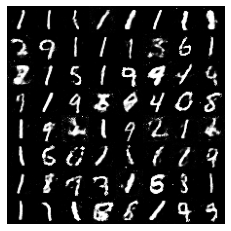

In [23]:
loss_train_G = []
loss_train_D = []

num_steps_D = 3

for epoch in range(200):

    loss_D = 0
    loss_G = 0

    for i, data in tqdm(enumerate(train_dl), total=len(train_dl)):
        data_real = data[0].to(device)  # Don't need the label
        batch_size = data_real.shape[0]

        for j in range(num_steps_D):
          # Train discriminator
          data_fake = generator(generate_noise(batch_size, 64)).detach()
          loss_D += train_discriminator(optim_d, data_real, data_fake).item()

        # Train generator
        data_fake = generator(generate_noise(batch_size, 64))
        loss_G += train_generator(optim_g, data_fake).item()

    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    #print(generated_img.shape)
    # make the image a square
    #square_img = torch.reshape(generated_img, (-1,28,28))
    #generated_img = make_grid(generated_img)
    #save_generator_image(generated_img, f"GAN_images/gen_img{epoch}.png")
    #images.append(generated_img)

    #square_img = torch.reshape(square_img, (280, 280))
    patcher(generated_img, epoch)
    # save the generated torch tensor models to disk
    #save_generator_image(square_img, "GAN_images/{}.png".format(epoch))

    loss_G /= (i+1)
    loss_D /= ((j+1)*(i+1))

    loss_train_G.append(loss_G)
    loss_train_D.append(loss_D)
    print("Epoch:{}, Loss_G:{}, Loss_D:{}".format(epoch, loss_G, loss_D))

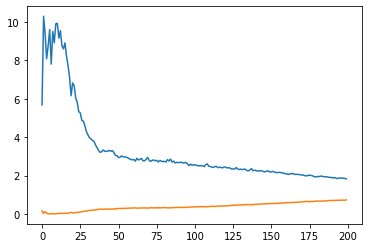

In [24]:
plt.plot(loss_train_G)
plt.plot(loss_train_D)
plt.show()